<a href="https://colab.research.google.com/github/Shahid1993/colab-notebooks/blob/master/conditional_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing Enron Email Data

In [0]:
#To mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#!unzip ./sample_data/enron-email-dataset.zip -d ./sample_data

In [0]:
import pandas as pd

In [0]:
# data = pd.read_csv("./sample_data/emails.csv")
# pd.set_option('display.max_colwidth',-1)
# new = data["message"].str.split("\n", n = 15, expand = True) 

In [0]:
#new.head(2)

In [0]:
#data.head(2)

In [0]:
# data["from"] = new[2]
# data["fromn"] = new[8]
# data["to"] = new[3]
# data["ton"] = new[9]
# data["subject"] = new[4]
# data["msg"] = new[15]
# data.drop(columns =["message"], inplace = True) 
# data.drop(columns =["file"], inplace = True) 

In [0]:
# data.head(2)

In [0]:
# data['from'] = data["from"].apply(lambda val: val.replace("From:",''))
# data['fromn'] = data["fromn"].apply(lambda val: val.replace("X-From:",''))
# data['to'] = data["to"].apply(lambda val: val.replace("To:",''))
# data['ton'] = data["ton"].apply(lambda val: val.replace("X-To:",''))
# data['subject'] = data["subject"].apply(lambda val: val.replace("Subject:",''))
# data['msg'] = data["msg"].apply(lambda val: val.replace("\n",' '))

In [0]:
# data.head(2)

In [0]:
# Lets look only at emails with 100 words or less and that are Non-replies
# data[(data['msg'].str.len() <100) & ~(data['subject'].str.contains('Re:'))].sample(5)

In [0]:
# data.head()['msg']

In [0]:
# corpus = [msg for msg in data[(data['msg'].str.len() <100) & ~(data['subject'].str.contains('Re:'))]['msg']]

In [0]:
# corpus[60:69]

In [0]:
# len(corpus)

In [0]:
#Taking only as subset of corpus, since it takes lot of time for training
# corpus = corpus[0:10000]

file = open("./drive/My Drive/ML/data/smart_compose.txt", 'r')
corpus = [line for line in file]

In [6]:
len(corpus)

158915

In [0]:
from random import sample

corpus = sample(corpus, 25000)

In [9]:
len(corpus)

25000

In [10]:
corpus[60:75]

['A naked woman is taking a dip in an isolated rocky pool .\n',
 "As a medium haired brunette wearing a brown shirt leans forward and looks on , an auburn-haired woman in a gray shirt is laughing , her head reared back somewhat as she holds a blue infant outfit , its price tag hanging just below the woman 's left hand .\n",
 'A man wearing a bright neon orange vest sitting by a parked truck with his laptop .\n',
 'Three college-aged students eat a meal .\n',
 'Black man sells various toys in the street .\n',
 'a woman kissing a child in the middle of the street\n',
 'Man riding a unbroken horse or bronco .\n',
 'Two kids joyfully sledding downhill .\n',
 'People pass each other on a busy city street while talking on their cellphones .\n',
 'Several men in hard hats are operating a giant pulley system .\n',
 'A black woman in a pink shirt , eating a muffin , is selling ducks and other toys at some special event .\n',
 'Man in plaid shirt leaning against a wall .\n',
 'A blond-haired boy

In [11]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'1.14.0'

In [0]:
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

      
def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline= clean_special_chars(line.lower(), punct)
         output.append(pline)
    return output  


def generate_dataset():
  
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df            

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df


In [14]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

Dataset prepared with prefix and suffixes for teacher forcing technique


In [18]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[30:65]

,input,output
30,<start> young blond child in gray shirt <end>,<start> playing in a cardboard box . <end>
31,<start> young blond child in gray shirt p <end>,<start> laying in a cardboard box . <end>
32,<start> young blond child in gray shirt pl <end>,<start> aying in a cardboard box . <end>
33,<start> young blond child in gray shirt pla <end>,<start> ying in a cardboard box . <end>
34,<start> young blond child in gray shirt play <end>,<start> ing in a cardboard box . <end>
35,<start> young blond child in gray shirt playi <end>,<start> ng in a cardboard box . <end>
36,<start> young blond child in gray shirt playin <end>,<start> g in a cardboard box . <end>
37,<start> young blond child in gray shirt playing <end>,<start> in a cardboard box . <end>
38,<start> young blond child in gray shirt playing <end>,<start> in a cardboard box . <end>
39,<start> young blond child in gray shirt playing i <end>,<start> n a cardboard box . <end>


In [19]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 300)      8075400     input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 75, 256), (N 440320      embedding_2[0][0]                
____________________________________________________________________________________________

In [21]:
# Note, we use 20% of our data for validation.
epochs = 4
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

Train on 1265519 samples, validate on 316380 samples
Epoch 1/4
1265519/1265519 [==============================] - 9281s 7ms/sample - loss: 0.3934 - sparse_categorical_accuracy: 0.9291 - val_loss: 0.2590 - val_sparse_categorical_accuracy: 0.9462
Epoch 2/4
1265519/1265519 [==============================] - 9279s 7ms/sample - loss: 0.2536 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.2009 - val_sparse_categorical_accuracy: 0.9568
Epoch 3/4
1265519/1265519 [==============================] - 9262s 7ms/sample - loss: 0.2169 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.1773 - val_sparse_categorical_accuracy: 0.9615
Epoch 4/4
1265519/1265519 [==============================] - 9296s 7ms/sample - loss: 0.1987 - sparse_categorical_accuracy: 0.9564 - val_loss: 0.1646 - val_sparse_categorical_accuracy: 0.9643


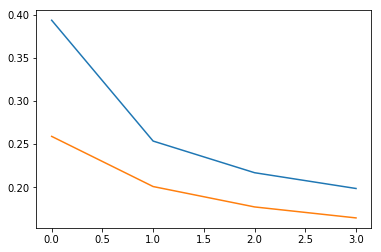

In [22]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [0]:


# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])



In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [34]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.


test = [
    'hi there',
    'hell',
    'presentation please fin',
    'have a nice we',
    'let me ',
    'christmas Merry ',
    'please rev',
    'please ca',
    'thanks fo',
    'Let me kno',
    'Let me know if y',
    'this soun',
    'is this call going t',
    'A man si',
    'Dog bar',
    'blue sky',
    'book on a ta'
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,hi there,a man are standing in front of a large group of people .
1,hell,l a young boy are playing in a sprinkler .
2,presentation please fin,"people are performing notes , one of them , the other wearing a green shirt , who is wearing a black shirt with a yellow cozy attached to the side ."
3,have a nice we,man are performing a takedown maneuver on a similarly dressed man .
4,let me,in a white and white room with a percussionist .
5,christmas merry,in a field of melting snow .
6,please rev,people are gathered around a table with glow sticks on it .
7,please ca,people are walking down a street .
8,thanks fo,people are in a city .
9,let me kno,of the people are performing a dance routine .


In [0]:
# This is to save the model for the web app to use for generation
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = inf_model.to_json()


with open("./drive/My Drive/ML/data/model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
inf_model.save_weights("./drive/My Drive/ML/data/model_num.h5")